In [3]:
# imports
import os
os.sys.path.append("../")
import numpy as np
import scipy as sp
from scipy import signal
import sklearn as sk
from sklearn import neighbors
import preprocessing as pp
import utilities as u
import MAPInference as mapi
from matplotlib import pyplot as plt
import pickle

from scipy.interpolate import interp1d as spline
from sklearn.linear_model import HuberRegressor as hreg
from sklearn.linear_model import LinearRegression as lreg
from sklearn.decomposition import PCA as pca
from scipy.optimize import minimize
import UnityTransforms as ut

import SimulatedSimMats as ssm

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [7]:
df = pp.load_session_db(dir='D:\\')
# df = pp.load_session_db()
df = df[df['RewardCount']>40]
df = df[df['Imaging']==1]
df = df.sort_values(['MouseName','DateTime','SessionNumber'])
df = df[df["Track"]=="TwoTower_foraging"]

In [8]:
df_mouse=df[df["MouseName"]=="4222153.2"]
df_mouse

,MouseName,DateFolder,SessionNumber,Track,RewardCount,Imaging,ImagingRegion,DateTime,data file,scanmat,s2pfolder
1727,4222153.2,08_04_2019,1,TwoTower_foraging,86,1,CA1,2019-04-08,D:\VR_Data\TwoTower\4222153.2\08_04_2019\TwoTo...,None,None
1751,4222153.2,10_04_2019,3,TwoTower_foraging,80,1,CA1,2019-04-10,D:\VR_Data\TwoTower\4222153.2\10_04_2019\TwoTo...,None,None
1771,4222153.2,12_04_2019,2,TwoTower_foraging,86,1,CA1,2019-04-12,D:\VR_Data\TwoTower\4222153.2\12_04_2019\TwoTo...,None,None
1788,4222153.2,14_04_2019,2,TwoTower_foraging,96,1,CA1,2019-04-14,D:\VR_Data\TwoTower\4222153.2\14_04_2019\TwoTo...,None,None
1800,4222153.2,15_04_2019,2,TwoTower_foraging,103,1,CA1,2019-04-15,D:\VR_Data\TwoTower\4222153.2\15_04_2019\TwoTo...,None,None
1816,4222153.2,16_04_2019,2,TwoTower_foraging,98,1,CA1,2019-04-16,D:\VR_Data\TwoTower\4222153.2\16_04_2019\TwoTo...,None,None
1825,4222153.2,17_04_2019,2,TwoTower_foraging,77,1,CA1,2019-04-17,D:\VR_Data\TwoTower\4222153.2\17_04_2019\TwoTo...,None,None
1833,4222153.2,18_04_2019,3,TwoTower_foraging,70,1,CA1,2019-04-18,D:\VR_Data\TwoTower\4222153.2\18_04_2019\TwoTo...,None,None


In [26]:
sess = df_mouse.iloc[-1]
with open(os.path.join("D:\\Suite2P_Data\\",sess["MouseName"],"%s_%s_%i.pkl" % (sess["Track"],sess["DateFolder"],sess["SessionNumber"])),'rb') as f:
    data = pickle.load(f)
print(data.keys())
ops = np.load("E:\\2P_Data\\TwoTower\\4222153.2\\18_04_2019\\TwoTower_foraging\\TwoTower_foraging_003_003\\suite2p\\plane0\\ops.npy",allow_pickle=True).item()
stat = np.load("E:\\2P_Data\\TwoTower\\4222153.2\\18_04_2019\\TwoTower_foraging\\TwoTower_foraging_003_003\\suite2p\\plane0\\stat.npy",allow_pickle=True)
iscell = np.load("E:\\2P_Data\\TwoTower\\4222153.2\\18_04_2019\\TwoTower_foraging\\TwoTower_foraging_003_003\\suite2p\\plane0\\iscell.npy",allow_pickle=True)

dict_keys(['VRDat', 'C', 'S', 'dFF', 'trial_info', 'tstart_inds', 'teleport_inds', 'S_trial_mat', 'occ_trial_mat', 'edges', 'centers'])


dict_keys(['look_one_level_down', 'fast_disk', 'delete_bin', 'mesoscan', 'h5py', 'h5py_key', 'save_path0', 'subfolders', 'nplanes', 'nchannels', 'functional_chan', 'diameter', 'tau', 'fs', 'save_mat', 'combined', 'num_workers', 'num_workers_roi', 'do_registration', 'keep_movie_raw', 'nimg_init', 'batch_size', 'maxregshift', 'align_by_chan', 'reg_tif', 'reg_tif_chan2', 'subpixel', 'do_phasecorr', 'smooth_sigma', 'nonrigid', 'block_size', 'snr_thresh', 'maxregshiftNR', 'connected', 'navg_frames_svd', 'nsvd_for_roi', 'max_iterations', 'smooth_masks', 'threshold_scaling', 'max_overlap', 'ratio_neuropil', 'ratio_neuropil_to_cell', 'tile_factor', 'inner_neuropil_radius', 'outer_neuropil_radius', 'min_neuropil_pixels', 'high_pass', 'chan2_thres', 'baseline', 'win_baseline', 'sig_baseline', 'prctile_baseline', 'neucoeff', 'allow_overlap', 'xrange', 'yrange', 'save_path', 'ops_path', 'reg_file', 'meanImg', 'nframes', 'Ly', 'Lx', 'yblock', 'xblock', 'nblocks', 'NRsm', 'reg_file_raw', 'refImg', '

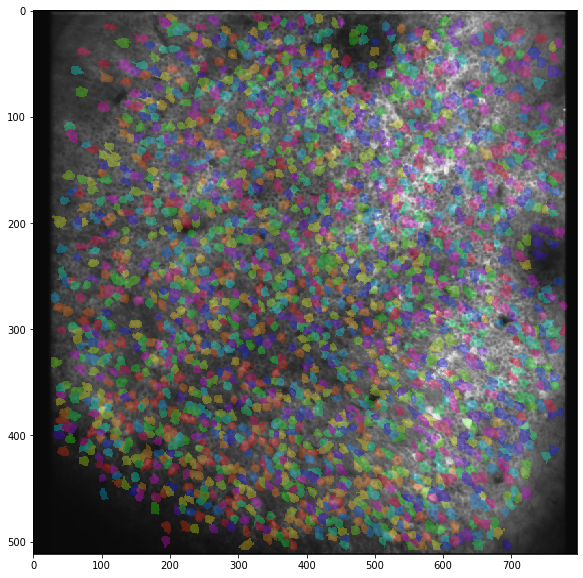

In [31]:
print(ops.keys())
f,ax = plt.subplots(figsize=[10,10])
ax.imshow(ops['meanImg'],aspect=796./512,cmap='Greys_r')


stat_cells = stat[iscell[:,0]>0]
# plot ROIs
roi_im = np.zeros((ops['Ly'], ops['Lx']))
roi_im[:]=np.nan

for n in range(0,len(stat_cells)):
    ypix = stat_cells[n]['ypix']
    xpix = stat_cells[n]['xpix']
    roi_im[ypix,xpix] = n
    
ax.imshow(roi_im,cmap='hsv',alpha=.3,aspect=796/512.)
f.savefig("D:\\Morph_Results\\figures\\exampleFOV.pdf",format="pdf")

In [ ]:
# MAP estimates

In [2]:
# make sqlite file with data from paper only 
# also need to make G drive folder that only contains that data

In [3]:
# plot example place cells with cosine similarity matrix

In [4]:
# calculate place cells in each session and make population plots